TODO: option to save everything as SVG and CSV, and add statistics for CDFs,  add n for metrics

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import seaborn as sns
from collections import namedtuple
from scipy.optimize import curve_fit
from ht2.io_handler import *

sns.set_theme("notebook", "white")

def batch_read_idealized(fpath_list):
    idl_df = []
    for i, fpath in enumerate(fpath_list):
        raw_trace = pd.read_csv(fpath, sep="\s+", index_col=False, header=None)
        raw_trace.columns = ["x", "y", "I", "t", "spots"]
        idl_trace = fpath.parent.joinpath(fpath.name[:-4] + "_idealized_traces.txt")
        idl_trace = pd.read_csv(idl_trace, sep="\s+", index_col=False, header=None)
        G = idl_trace[0]
        G[G == G.max()] = 1
        G[G == G.min()] = 0
        raw_trace["Normalized Intensity"] = raw_trace["I"] - np.percentile(raw_trace["I"], 30)
        raw_trace["Normalized Intensity"] = raw_trace["Normalized Intensity"] / np.percentile(raw_trace["Normalized Intensity"], 98)
        raw_trace["Time (min)"] = raw_trace["t"] * 100 / 60
        raw_trace["State"] = idl_trace[0]
        idl_df.append(raw_trace)
    return idl_df

def read_cond_traces(cond_path: Path):
    cpath = cond_path.joinpath("coupled")

    cg_trace_list = cpath.glob("*G_Dual*.trk")
    cg_trace_df = batch_read_idealized(cg_trace_list)
    cr_trace_list = cpath.glob("*R_Dual*.trk")
    cr_trace_df = batch_read_idealized(cr_trace_list)

    return {"G":cg_trace_df, "R":cr_trace_df}

In [82]:
parent_path = Path(r"C:\Users\Imageanalysis\Desktop\Ike\New")
path_list = sorted(parent_path.glob("*/"))
cond_names = ["Fibronectin", 
              "Laminin", 
              "Soft FN", 
              "Soft Lam", 
              "Stiff FN", 
              "Stiff Lam", 
              "20% Stretch", 
              "0% Stretch", 
              "Control", 
              "Hypotonic", 
              "Compression"]
[print(dirpath.name, " || ", cond) for dirpath, cond in zip(path_list, cond_names)]

001-1MaxIP_fn  ||  Fibronectin
001-1MaxIP_lam  ||  Laminin
003-4_soft_fn  ||  Soft FN
003-4_soft_lam  ||  Soft Lam
003-4_stiff_fn  ||  Stiff FN
003-4_stiff_lam  ||  Stiff Lam
004-4MaxIP_STRETCH_20  ||  20% Stretch
005-1MaxIP_STRETCH_0  ||  0% Stretch
009-0Cont  ||  Control
47_49HypOtonic_hyp_ctrl  ||  Hypotonic
56Compression  ||  Compression


[None, None, None, None, None, None, None, None, None, None, None]

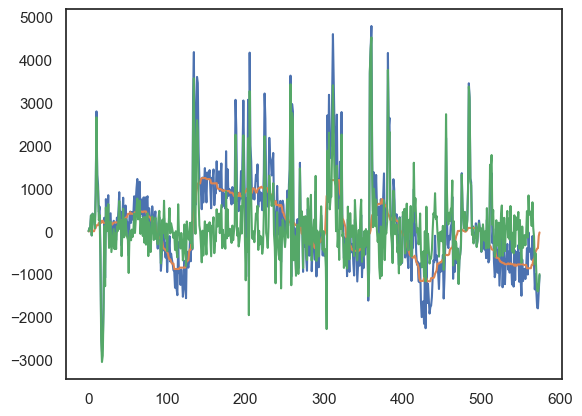

In [191]:
import scipy.signal as sig

filter = sig.medfilt

def unsharp_mask(signal):

    med = sig.medfilt(signal, 31)
    return signal - med, med

test_sig = results["G"][0]["I"]
test_sig = test_sig - test_sig[0]
high_pass, low_pass = unsharp_mask(test_sig)
plt.plot(test_sig)
plt.plot(low_pass)
plt.plot(high_pass)
plt.show()

In [145]:
t_start = [trace["t"][np.argmax(trace["Normalized Intensity"] > 0.3)]for trace in results["G"]]
sort_idx = np.argsort(t_start)

In [146]:
G_sorted = [results["G"][i] for i in sort_idx]
R_sorted = [results["R"][i] for i in sort_idx]

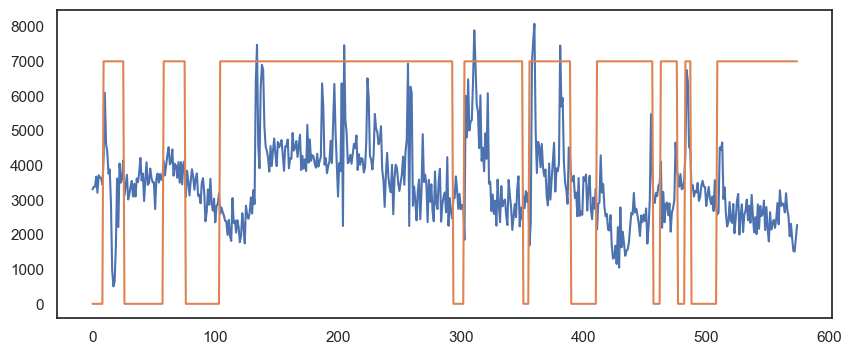

In [165]:
plt.figure(figsize=(10, 4))
plt.plot(results["G"][0]["I"])
plt.plot(results["G"][0]["State"] * 7000)

In [ ]:
def arrange_heatmap(results, max_length=0, spacing=0):
    t_start = [trace["t"][np.argmax(trace["Normalized Intensity"])]for trace in results["R"]]
    sort_idx = np.argsort(t_start)
    G_df = [results["G"][i] for i in sort_idx]
    R_df = [results["R"][i] for i in sort_idx]
    # G_df = results["G"]
    # R_df = results["R"]
    heat_map_arr = np.ones((len(G_df) * (2+spacing), max_length)) * 0.5
    for i in range(len(G_df)):
        G_df[i]["trace"], R_df[i]["trace"] = i, i

    # G_df = pd.concat(G_df)
    # R_df = pd.concat(R_df)
    # heat_map_arr = np.zeros()
    for i, (g_trace, r_trace) in enumerate(zip(G_df, R_df)):
        g_vals = g_trace["Normalized Intensity"][0:min(len(g_trace["t"]), max_length)]
        g_vals[g_vals < 0] = 0
        g_vals[g_vals > 1] = 1
        g_vals = g_vals / 2 + 0.5
        r_vals = r_trace["Normalized Intensity"][0:min(len(g_trace["t"]), max_length)]
        r_vals[r_vals < 0] = 0
        r_vals[r_vals > 1] = 1
        r_vals = 0.5 - r_vals / 2
        heat_map_arr[i * (2+spacing), 0:min(len(g_trace["t"]), max_length)] = g_vals
        heat_map_arr[i * (2+spacing) + 1, 0:min(len(r_trace["t"]), max_length) ] = r_vals

    return heat_map_arr

def heatmap_csv(results, out):
    df = {}
    for i, (g_trace, r_trace) in enumerate(zip(results["G"], results["R"])):
        g_vals = g_trace["Normalized Intensity"].copy()
        g_vals[g_vals < 0] = 0
        g_vals[g_vals > 1] = 1
        r_vals = r_trace["Normalized Intensity"].copy()
        r_vals[r_vals < 0] = 0
        r_vals[r_vals > 1] = 1
        df["{}_G".format(i)] = g_vals
        df["{}_R".format(i)] = r_vals
    df = pd.DataFrame(df)
    df.to_csv(out)
    return df

df = heatmap_csv(results, "figure_dump/control_norm_intensities.csv")

,0_G,0_R,1_G,1_R,2_G,2_R,3_G,3_R,4_G,4_R,...,27_G,27_R,28_G,28_R,29_G,29_R,30_G,30_R,31_G,31_R
0,0.124338,0.000000,0.243447,0.240819,0.127446,0.310804,0.353237,0.000000,0.042118,0.458242,...,0.020956,0.722538,0.187301,0.480629,0.509926,0.0,0.0,0.036579,0.000000,0.000000
1,0.143100,0.000000,0.120239,0.014737,0.000000,0.304372,0.674564,0.000000,0.000000,0.621583,...,0.104065,0.889443,0.220506,0.443785,0.197335,0.0,0.0,0.000000,0.082316,0.000000
2,0.143995,0.000000,0.198112,0.000000,0.170978,0.164930,0.880430,0.000000,0.000000,0.633147,...,0.629821,0.796695,0.642794,0.508276,0.210710,0.0,0.0,0.000000,0.159521,0.017816
3,0.220606,0.000000,0.334578,0.000000,0.096380,0.231259,0.375051,0.074945,0.000000,0.668288,...,0.800968,1.000000,0.064244,0.500844,0.036817,0.0,0.0,0.000000,0.128708,0.000000
4,0.098638,0.000000,0.342060,0.000000,0.155210,0.014732,0.415556,0.013648,0.018715,0.476669,...,0.544648,0.672432,0.308892,0.480534,0.053549,0.0,0.0,0.000000,0.050969,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,0.000000,0.000000,0.000000,0.455468,0.178438,0.226026,0.090326,0.000000,NaN,NaN,...,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
571,0.000000,0.000000,0.000000,0.284864,0.280829,0.318929,0.153212,0.000000,NaN,NaN,...,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
572,0.000000,0.046713,0.000000,0.302980,0.334650,0.289565,0.087544,0.000000,NaN,NaN,...,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
573,0.000000,0.000000,NaN,NaN,0.236863,0.443540,0.119513,0.000000,NaN,NaN,...,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


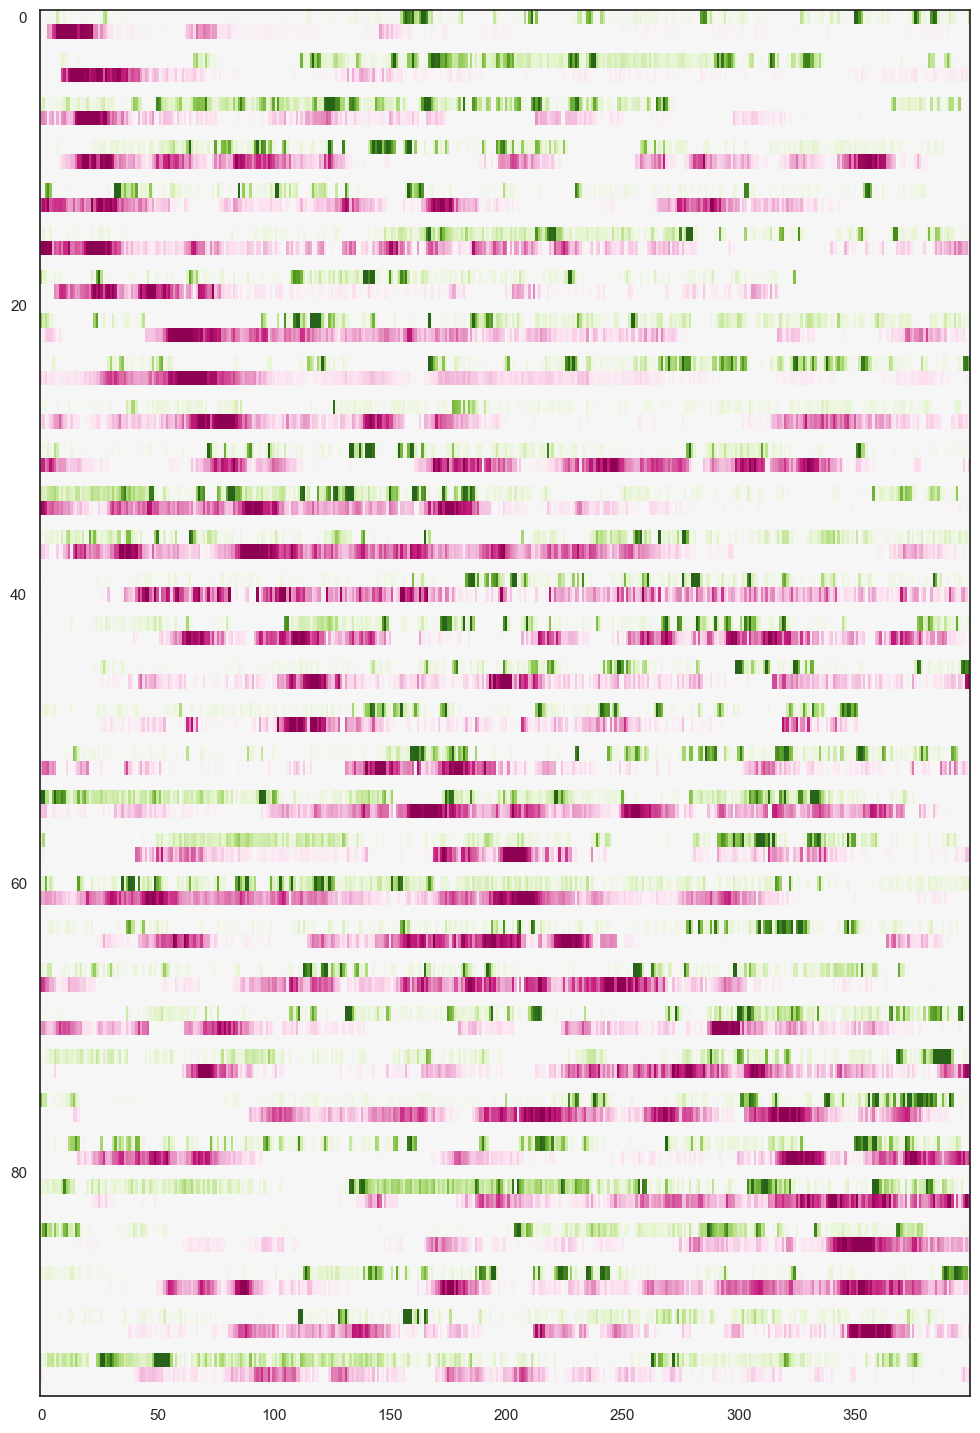

In [162]:
results = read_cond_traces(path_list[-3])
heatmap_arr = arrange_heatmap(results, 400, spacing=1)
plt.figure(figsize=(12, 18))
plt.imshow(heatmap_arr, aspect="auto", interpolation="nearest", cmap="PiYG")
plt.show()